# Prerequisites

## Packages

In [1]:
!pip install -U accelerate peft transformers einops datasets bitsandbytes

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 1.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.4 MB/s eta 0:00:00
  Attempting uninstall: einops
    Found existing installation: einops 0.4.1
    Uninstalling einops-0.4.1:
      Successfully uninstalled einops-0.4.1
  Attempting uninstall: peft
    Found existing installation: peft 0.7.1
    Uninstalling peft-0.7.1:
      Successfully uninstalled peft-0.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
trlx 0.7.0 requires deepspeed>=0.8.1, which is not installed.


In [3]:
!pip freeze | egrep "accelerate|peft|transformers|einops|datasets|^torch=|bitsandbytes" 

accelerate==0.26.1
bitsandbytes==0.42.0
datasets==2.16.1
einops==0.7.0
peft==0.8.1
torch==2.1.0
transformers==4.37.2


## Set a seed for reproducibility of the training process

In [4]:
from transformers import set_seed

set_seed(42)

# Load model and tokenizer

## Load model in 4 bit

In [6]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

# Load model
modelpath = "microsoft/phi-2"
model = AutoModelForCausalLM.from_pretrained(
    modelpath,    
    device_map="auto",
    quantization_config=BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_quant_type="nf4",
    ),
    torch_dtype=torch.bfloat16,
    # FA2 does not work yet
    # attn_implementation="flash_attention_2",          
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
model

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (q_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (dense): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear4bit(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear4bit(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (final_layern

## Load tokenizer

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(modelpath, use_fast=False)    # fast tokenizer sometimes ignores the added tokens

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
len(tokenizer)

50295

## Add ChatML tokens to tokenizer

In [9]:
tokenizer.add_tokens(["<|im_start|>", "<PAD>"])
tokenizer.pad_token = "<PAD>"
tokenizer.add_special_tokens(dict(eos_token="<|im_end|>"))
model.config.eos_token_id = tokenizer.eos_token_id

Note: there is no need to rezise the token embeddings, phi-2 already has embeddings sized for additional tokens. The model's vocab. size is 51200, this means you can add ~700 tokens to the tokenizer without having to resize the embeddings. 

In [10]:
model.model.embed_tokens

Embedding(51200, 2560)

## Prepare LoRA adapters

In [11]:
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=False) 

lora_config = LoraConfig(
    r=32, 
    lora_alpha=32, 
    target_modules = [ "q_proj", "k_proj", "v_proj", "dense" ],
    modules_to_save = ["lm_head", "embed_tokens"],
    lora_dropout=0.1, 
    bias="none", 
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, lora_config)

model.config.use_cache = False

# Load and preprocess dataset

In [12]:
from datasets import load_dataset

dataset = load_dataset("g-ronimo/riddles_evolved")
dataset = dataset["train"].train_test_split(test_size=0.1)

In [13]:
dataset

DatasetDict({
    train: Dataset({
        features: ['number', 'messages'],
        num_rows: 1513
    })
    test: Dataset({
        features: ['number', 'messages'],
        num_rows: 169
    })
})

In [14]:
dataset["train"][0]

{'number': 1509,
 'messages': ["What starts with a 'C' is covered with keys, but we use only one. What is it?",
  'The answer to the riddle is a "coconut." While a coconut is covered with many small "keys" or eyes, we typically open it with just one tool, such as a coconut crusher or a large nail.',
  "Cool, so what's that thing we eat that looks like a big brown ball and has lots of little bumps on it, but we only use one thing to open it? I guess it's not a basketball?",
  'I believe you\'re referring to an artichoke. While an artichoke looks like a large brown ball with small bumps on it, we typically use a tool called a "dip tool" or a "lemon tool" with a sharp tip or a pair of scissors to remove the small, sharp thorns covering the artichoke\'s bracts, allowing us to eat the tender heart inside.']}

## Apply ChatML format and tokenize

In [21]:
import os
from functools import partial

# Format (chatML) and tokenize dataset
templates=[
    "<|im_start|>assistant\n{msg}<|im_end|>",
    "<|im_start|>user\n{msg}<|im_end|>"
]
IGNORE_INDEX=-100

def tokenize(input, max_length):
    input_ids, attention_mask, labels = [], [], []

    for i,msg in enumerate(input["messages"]):
        isHuman = i%2==0
        msg_chatml=templates[isHuman].format(msg=msg)
        msg_tokenized=tokenizer(msg_chatml, truncation=False, add_special_tokens=False)

        input_ids+=msg_tokenized["input_ids"]
        attention_mask+=msg_tokenized["attention_mask"]
        labels+=[IGNORE_INDEX]*len(msg_tokenized["input_ids"]) if isHuman else msg_tokenized["input_ids"]

    return {
        "input_ids": input_ids[:max_length],
        "attention_mask": attention_mask[:max_length],
        "labels": labels[:max_length],
    }

dataset_tokenized = dataset.map(
    partial(tokenize, max_length=1024), # max sample length 1024 tokens, enough for this dataset
    batched=False, 
    num_proc=os.cpu_count(),    # multithreaded
    remove_columns=dataset["train"].column_names  # don't need this anymore, we have tokens from here on
)

Map (num_proc=32):   0%|          | 0/1513 [00:00<?, ? examples/s]

Map (num_proc=32):   0%|          | 0/169 [00:00<?, ? examples/s]

longest sample: 952 tokens


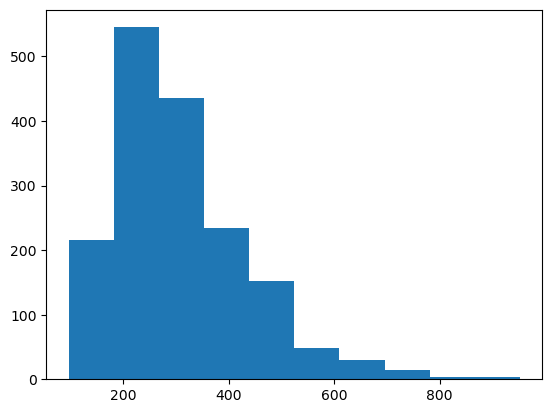

In [22]:
# Sample size distribution
import matplotlib.pyplot as plt

data = [len(tok) for tok in (dataset_tokenized["train"]["input_ids"]+dataset_tokenized["test"]["input_ids"])] 
print(f"longest sample: {max(data)} tokens")

plt.hist(data, bins=10)  
plt.show()

## Define a collate function, train on answers only

In [23]:
# collate function - to transform list of dictionaries [ {input_ids: [123, ..]}, {.. ] to single batch dictionary { input_ids: [..], labels: [..], attention_mask: [..] }
def collate(elements):
    tokens=[e["input_ids"] for e in elements]
    tokens_maxlen=max([len(t) for t in tokens])

    for i,sample in enumerate(elements):
        input_ids=sample["input_ids"]
        labels=sample["labels"]
        attention_mask=sample["attention_mask"]

        pad_len=tokens_maxlen-len(input_ids)

        input_ids.extend( pad_len * [tokenizer.pad_token_id] )   
        labels.extend( pad_len * [IGNORE_INDEX] )    
        attention_mask.extend( pad_len * [0] ) 

    batch={
        "input_ids": torch.tensor( [e["input_ids"] for e in elements] ),
        "labels": torch.tensor( [e["labels"] for e in elements] ),
        "attention_mask": torch.tensor( [e["attention_mask"] for e in elements] ),
    }

    return batch

# Train

## Set hyperparameters

In [24]:
from transformers import TrainingArguments, Trainer

# dataset-specific parameters
bs=1     # batch size for training
bs_eval=16    # batch size for evaluation
ga_steps=16  # gradient accumulation steps
lr=0.00002  # learning rate
epochs=20

steps_per_epoch=len(dataset_tokenized["train"])//(bs*ga_steps)

args = TrainingArguments(
    output_dir="out",
    per_device_train_batch_size=bs,
    per_device_eval_batch_size=bs_eval,
    evaluation_strategy="steps",
    logging_steps=1,
    eval_steps=steps_per_epoch//2,    # 2 evals per epoch
    save_steps=steps_per_epoch,     # save once per epoch
    gradient_accumulation_steps=ga_steps,
    num_train_epochs=epochs,
    lr_scheduler_type="constant",
    optim="paged_adamw_32bit",      # val_loss will go nan with paged_adamw_8bit
    learning_rate=lr,
    group_by_length=False,
    bf16=True,        
    ddp_find_unused_parameters=False,
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=collate,
    train_dataset=dataset_tokenized["train"],
    eval_dataset=dataset_tokenized["test"],
)

In [ ]:
# log to a specific wandb project
import wandb 
run = wandb.init(
    project="phi2",
    name="testrun",
)

## Start training

In [ ]:
trainer.train()

# After training: Merge LoRA adapters with base model

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from peft import PeftModel
import torch

# base model
base_path="microsoft/phi-2"  

# adapters: path to folder with adapter_model.safetensors
adapter_path="out/checkpoint-1880" 

# where to save merged model
save_to="trained_model"       

# Load model and tokenizer
base_model = AutoModelForCausalLM.from_pretrained(
    base_path,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
tokenizer = AutoTokenizer.from_pretrained(base_path)

# Add/set tokens same tokens to base model before merging, like we did before training  
tokenizer.add_tokens(["<|im_start|>", "<PAD>"])
tokenizer.pad_token = "<PAD>"
tokenizer.add_special_tokens(dict(eos_token="<|im_end|>"))

# Add ChatML template to tokenizer
tokenizer.chat_template="{% if not add_generation_prompt is defined %}{% set add_generation_prompt = false %}{% endif %}{% for message in messages %}{{'<|im_start|>' + message['role'] + '\n' + message['content'] + '<|im_end|>' + '\n'}}{% endfor %}{% if add_generation_prompt %}{{ '<|im_start|>assistant\n' }}{% endif %}"

base_model.config.eos_token_id = tokenizer.eos_token_id

# Set a default Generation configuration: Llama precise
generation_config = GenerationConfig(
    max_new_tokens=100, 
    temperature=0.7,
    top_p=0.1,
    top_k=40,
    repetition_penalty=1.18,
    do_sample=True,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
)

# Load LoRA and merge
model = PeftModel.from_pretrained(base_model, adapter_path)
model = model.merge_and_unload()

model.save_pretrained(save_to, safe_serialization=True, max_shard_size='4GB')
tokenizer.save_pretrained(save_to)
generation_config.save_pretrained(save_to)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Inference of trained model

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from peft import PeftModel
import torch

model_path="trained_model"    
question="Hello, who are you?"

model = AutoModelForCausalLM.from_pretrained(
        model_path,    
        torch_dtype=torch.bfloat16,
        device_map="auto"
    )
tokenizer = AutoTokenizer.from_pretrained(model_path) 

messages=[
    {"role": "user", "content": question}
]
        
input_tokens = tokenizer.apply_chat_template(
    messages, 
    add_generation_prompt=True,
    return_tensors="pt"
).to("cuda")

output_tokens = model.generate(input_tokens)
output = tokenizer.decode(
    output_tokens[0][len(input_tokens[0]):],
    skip_special_tokens=True
    )               

print(output)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


I am an artificial intelligence language model designed to help answer questions and provide information. I don't have a specific identity or creator like humans do. If there's any particular question you'd like me to help with, feel free to ask!


# Upload model to hub

In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import 

# Load model and tokenizer
modelpath="trained_model"
model = AutoModelForCausalLM.from_pretrained(
    modelpath,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)
tokenizer = AutoTokenizer.from_pretrained(modelpath) 

# Upload
model.push_to_hub("g-ronimo/phi-2_riddles-evolved")
tokenizer.push_to_hub("g-ronimo/phi-2_riddles-evolved")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]